# Считываем данные

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
purchases = pd.read_excel('purchases.xlsx', sep='\t')

In [3]:
visits = pd.read_excel('visits.xlsx', sep='\t')

In [4]:
purchases.head(2)

,buy_ts,uid,revenue
0,23.07.2016 19:13:54,3492372810,"1,47"
1,06.11.2016 02:48:27,1564753091,"1,11"


In [5]:
visits.head(2)

,device,end_ts,source_id,start_dt,start_ts,uid
0,desktop,2016-11-30T11:04:17Z,2,2016-11-30,2016-11-30T10:53:49Z,3758486201
1,desktop,2016-11-10T23:16:57Z,4,2016-11-10,2016-11-10T23:08:04Z,2933941628


# Переводим даты в datetime

In [6]:
purchases['buy_ts_datetime'] = pd.to_datetime(purchases['buy_ts'], dayfirst=True)

visits['start_ts_datetime'] = pd.to_datetime(visits['start_ts'])

visits['end_ts_datetime'] = pd.to_datetime(visits['end_ts'])

In [7]:
visits.head(2)

,device,end_ts,source_id,start_dt,start_ts,uid,start_ts_datetime,end_ts_datetime
0,desktop,2016-11-30T11:04:17Z,2,2016-11-30,2016-11-30T10:53:49Z,3758486201,2016-11-30 10:53:49,2016-11-30 11:04:17
1,desktop,2016-11-10T23:16:57Z,4,2016-11-10,2016-11-10T23:08:04Z,2933941628,2016-11-10 23:08:04,2016-11-10 23:16:57


In [8]:
purchases.head(2)

,buy_ts,uid,revenue,buy_ts_datetime
0,23.07.2016 19:13:54,3492372810,"1,47",2016-07-23 19:13:54
1,06.11.2016 02:48:27,1564753091,"1,11",2016-11-06 02:48:27


In [9]:
visits['device'].value_counts(normalize=True)

desktop    0.731555
touch      0.268445
Name: device, dtype: float64

# Объединяем посещения с покупками

In [10]:
test_merge = pd.merge(visits, purchases, on='uid')

In [11]:
merged_df = test_merge[(test_merge['buy_ts_datetime'] >= test_merge['start_ts_datetime']) 
                       & (test_merge['buy_ts_datetime'] <= test_merge['end_ts_datetime'])]

merged_df.drop(['start_dt', 'start_ts', 'end_ts'], axis=1, inplace=True)

In [12]:
merged_df.head()

,device,source_id,uid,start_ts_datetime,end_ts_datetime,buy_ts,revenue,buy_ts_datetime
0,touch,4,3492372810,2016-07-23 19:10:57,2016-07-23 19:17:19,23.07.2016 19:13:54,"1,47",2016-07-23 19:13:54
3,desktop,1,3492372810,2017-04-18 15:17:26,2017-04-18 15:24:04,18.04.2017 15:19:31,"0,49",2017-04-18 15:19:31
4,desktop,5,1564753091,2016-11-06 02:38:06,2016-11-06 02:54:57,06.11.2016 02:48:27,"1,11",2016-11-06 02:48:27
14,desktop,3,1385616391,2017-01-31 20:14:56,2017-01-31 20:40:54,31.01.2017 20:32:42,"16,8",2017-01-31 20:32:42
25,desktop,2,1572918479,2016-12-04 01:05:13,2016-12-04 01:08:43,04.12.2016 01:05:43,"3,05",2016-12-04 01:05:43


In [13]:
merged_df.drop_duplicates(subset=['uid', 'revenue', 'buy_ts_datetime'], keep='first', inplace=True)

In [14]:
merged_df['revenue'] = merged_df['revenue'].apply(lambda x: float(x.replace(',', '.')))

In [152]:
pd.DataFrame(visits['source_id'].value_counts(normalize=True)) # С каких каналов люди посещают наш сервис

,source_id
4,0.283269
3,0.237032
5,0.186041
2,0.133370
1,0.095742
9,0.036763
10,0.027639
7,0.000126
6,0.000018


In [153]:
pd.DataFrame(merged_df['source_id'].value_counts(normalize=True)) # С каких каналов приходят люди, чтобы что-то купить

,source_id
4,0.239170
5,0.211395
3,0.208371
1,0.148978
2,0.136999
10,0.029531
9,0.025516
7,0.000040


In [16]:
merged_df['device'].value_counts(normalize=True) # Видим, что в основном покупают с копьютеров

desktop    0.838845
touch      0.161155
Name: device, dtype: float64

In [17]:
merged_df.groupby(['source_id'])['revenue'].median()

source_id
1     2.86
2     2.75
3     2.44
4     2.44
5     2.81
7     1.22
9     2.14
10    1.59
Name: revenue, dtype: float64

In [156]:
merged_df[merged_df['device'] == 'desktop']['source_id'].value_counts(normalize=True) 
#c каких каналов юзеры совершают покупки на компьютере

4     0.227965
5     0.222707
3     0.214362
1     0.146865
2     0.133593
10    0.028687
9     0.025774
7     0.000047
Name: source_id, dtype: float64

In [157]:
merged_df[merged_df['device'] == 'touch']['source_id'].value_counts(normalize=True)
#c каких каналов юзеры совершают покупки на смартфоне

4     0.297492
3     0.177184
1     0.159974
2     0.154729
5     0.152516
10    0.033929
9     0.024176
Name: source_id, dtype: float64

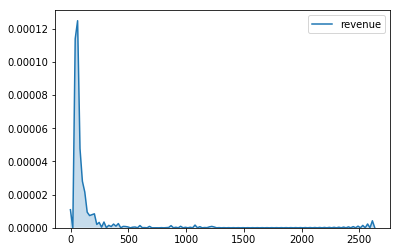

In [20]:
sns.kdeplot(merged_df['revenue'], shade=True);

### Создадим таблицы со статистикой переходов и покупок по каналам отдельно для desktop и touch

In [158]:
desktop_source_visits = pd.DataFrame(visits[visits['device'] == 'desktop'].groupby('source_id')['uid'].nunique())
#Кол-во посещений пользователей через desktop по каналам 

desktop_source_revenue = pd.DataFrame(merged_df[merged_df['device'] == 'desktop'].groupby('source_id')['revenue'].sum())
#Выручка от пользователей(desktop) по каналам

desktop_source = pd.merge(desktop_source_visits, desktop_source_revenue, left_index=True, right_index=True)
desktop_source.rename(columns={'uid': 'unique_uids'}, inplace=True)

Видим, что каналы **№1** и **№2** в среднем приносят больше выручки при меньших посещениях Афишы. Возможно, это те два канала, через которые люди целенаправленно идут на наш сервис, например, поиск в Яндексе или Google. Другие же каналы, возможно, являются каналами привлечения клиента, например, контекстная реклама (каналы 3, 4), которая собирает много кликов, но приносит меньше денег.

In [159]:
desktop_source['rev_per_uid'] = round(desktop_source['revenue']/ desktop_source['unique_uids'], 2)
desktop_source.sort_values(by='rev_per_uid', ascending=False)

,unique_uids,revenue,rev_per_uid
source_id,,,
1,22720,58938.50,2.59
2,30673,66207.33,2.16
5,76900,67550.12,0.88
4,101019,59794.51,0.59
3,106297,56474.49,0.53
10,10664,5183.40,0.49
9,11809,5389.07,0.46
7,62,3.34,0.05


Для смартфонов наблюдается похожая ситуация

In [150]:
touch_source_visits = pd.DataFrame(visits[visits['device'] == 'touch'].groupby('source_id')['uid'].nunique())
#Кол-во посещений пользователей через touch по каналам 

touch_source_revenue = pd.DataFrame(merged_df[merged_df['device'] == 'touch'].groupby('source_id')['revenue'].sum())
#Выручка от пользователей(touch) по каналам

touch_source = pd.merge(touch_source_visits, touch_source_revenue, left_index=True, right_index=True)
touch_source.rename(columns={'uid': 'unique_uids'}, inplace=True)

In [151]:
touch_source['rev_per_uid'] = round(touch_source['revenue']/ touch_source['unique_uids'], 2)
touch_source.sort_values(by='rev_per_uid', ascending=False)

,unique_uids,revenue,rev_per_uid
source_id,,,
1,10724,9977.90,0.93
2,15181,10326.32,0.68
4,53773,14567.36,0.27
5,28755,6823.12,0.24
3,35520,7805.46,0.22
9,4075,896.17,0.22
10,4440,886.99,0.20


In [161]:
pd.DataFrame(purchases['buy_ts_datetime'].apply(lambda x: x.month).value_counts())

# Кол-во покупок по месяцам

,buy_ts_datetime
12,9098
10,8774
11,8418
2,7855
3,7689
1,7065
5,6153
9,5336
4,4764
6,4009


In [28]:
purchases[purchases['buy_ts_datetime'].apply(lambda x: x.year) == 2016]['buy_ts_datetime'].apply(lambda date: date.month).value_counts()





12    9098
10    8774
11    8418
9     5336
6     4005
7     3721
8     2834
Name: buy_ts_datetime, dtype: int64

In [29]:
purchases[purchases['buy_ts_datetime'].apply(lambda x: x.year) == 2017]['buy_ts_datetime'].apply(lambda date: date.month).value_counts()





2    7855
3    7689
1    7065
5    6153
4    4764
6       4
Name: buy_ts_datetime, dtype: int64

In [30]:
visits[visits['start_ts_datetime'].apply(lambda x: x.year) == 2016]['start_ts_datetime'].apply(lambda date: date.month).value_counts()





11    88579
12    83820
10    75873
9     48328
7     35409
6     32935
8     28803
Name: start_ts_datetime, dtype: int64

In [31]:
visits[visits['start_ts_datetime'].apply(lambda x: x.year) == 2017]['start_ts_datetime'].apply(lambda date: date.month).value_counts()





2    74598
1    74137
3    71639
5    53693
4    52865
Name: start_ts_datetime, dtype: int64

In [32]:
visits['start_ts_datetime'].apply(lambda x: x.year).value_counts()

2016    393747
2017    326932
Name: start_ts_datetime, dtype: int64

In [33]:
purchases['buy_ts_datetime'].apply(lambda x: x.year).value_counts()

2016    42186
2017    33530
Name: buy_ts_datetime, dtype: int64

Наши данные содержат информацию о действиях юзеров за 2016:
-  июнь
-  июль
-  август
-  сентябрь
-  октябрь
-  ноябрь
-  декабрь

и за 2017 год:
-  январь
-  февраль
-  март
-  апрель
-  май

## Посчитаем LTV - деньги, которые принес юзер с момента первого посещения сервиса

In [34]:
first_visit = pd.DataFrame(visits.groupby('uid')['start_ts_datetime'].min()) #Таблица с датой первого посещения 

first_visit.reset_index(level=0, inplace=True)

first_visit.rename(columns={'start_ts_datetime': 'first_visit'}, inplace=True)

first_visit['first_visit'] = first_visit['first_visit'].apply(lambda x: str(x.month) + ' - ' + str(x.year))

In [163]:
first_visit.head()

,uid,first_visit
0,4245,11 - 2016
1,5097,2 - 2017
2,8896,1 - 2017
3,21017,6 - 2016
4,30696,11 - 2016


In [36]:
visits['month_year'] = visits['start_ts_datetime'].apply(lambda x: str(x.month) + ' - ' + str(x.year))

In [37]:
merged_df['month_year_visit'] = merged_df['start_ts_datetime'].apply(lambda x: str(x.month) + ' - ' + str(x.year))

merged_df['month_year_buy'] = merged_df['buy_ts_datetime'].apply(lambda x: str(x.month) + ' - ' + str(x.year))


In [38]:
merged_df[['uid', 'start_ts_datetime', 'buy_ts_datetime', 'revenue', 'month_year_visit', 'month_year_buy']].head(10)

,uid,start_ts_datetime,buy_ts_datetime,revenue,month_year_visit,month_year_buy
0,3492372810,2016-07-23 19:10:57,2016-07-23 19:13:54,1.47,7 - 2016,7 - 2016
3,3492372810,2017-04-18 15:17:26,2017-04-18 15:19:31,0.49,4 - 2017,4 - 2017
4,1564753091,2016-11-06 02:38:06,2016-11-06 02:48:27,1.11,11 - 2016,11 - 2016
14,1385616391,2017-01-31 20:14:56,2017-01-31 20:32:42,16.80,1 - 2017,1 - 2017
25,1572918479,2016-12-04 01:05:13,2016-12-04 01:05:43,3.05,12 - 2016,12 - 2016
46,1572918479,2016-12-01 20:13:47,2016-12-01 20:37:52,1.53,12 - 2016,12 - 2016
117,1572918479,2016-11-28 10:25:29,2016-11-28 10:33:08,5.25,11 - 2016,11 - 2016
128,1572918479,2016-11-28 22:51:50,2016-11-28 23:20:24,26.83,11 - 2016,11 - 2016
239,1572918479,2016-11-27 20:56:41,2016-11-27 22:10:57,5.19,11 - 2016,11 - 2016
330,1572918479,2016-11-29 20:35:10,2016-11-29 23:18:38,4.28,11 - 2016,11 - 2016


In [39]:
merged_df = pd.merge(merged_df, first_visit, on='uid')

merged_df.head()

,device,source_id,uid,start_ts_datetime,end_ts_datetime,buy_ts,revenue,buy_ts_datetime,month_year_visit,month_year_buy,first_visit
0,touch,4,3492372810,2016-07-23 19:10:57,2016-07-23 19:17:19,23.07.2016 19:13:54,1.47,2016-07-23 19:13:54,7 - 2016,7 - 2016,7 - 2016
1,desktop,1,3492372810,2017-04-18 15:17:26,2017-04-18 15:24:04,18.04.2017 15:19:31,0.49,2017-04-18 15:19:31,4 - 2017,4 - 2017,7 - 2016
2,desktop,5,1564753091,2016-11-06 02:38:06,2016-11-06 02:54:57,06.11.2016 02:48:27,1.11,2016-11-06 02:48:27,11 - 2016,11 - 2016,11 - 2016
3,desktop,3,1385616391,2017-01-31 20:14:56,2017-01-31 20:40:54,31.01.2017 20:32:42,16.80,2017-01-31 20:32:42,1 - 2017,1 - 2017,1 - 2017
4,desktop,2,1572918479,2016-12-04 01:05:13,2016-12-04 01:08:43,04.12.2016 01:05:43,3.05,2016-12-04 01:05:43,12 - 2016,12 - 2016,10 - 2016


In [183]:
uid_total_revenue = pd.DataFrame(merged_df.groupby('uid')['revenue'].sum()).reset_index() 

# сколько принес денег каждый чел

uid_total_revenue.rename(columns={'revenue': 'total revenue'}, inplace=True)


In [184]:
merged_df = pd.merge(merged_df, uid_total_revenue, on='uid')

In [185]:
merged_df.head()

,device,source_id,uid,start_ts_datetime,end_ts_datetime,buy_ts,revenue,buy_ts_datetime,month_year_visit,month_year_buy,first_visit,total_revenue,total revenue from first visit,total revenue
0,touch,4,3492372810,2016-07-23 19:10:57,2016-07-23 19:17:19,23.07.2016 19:13:54,1.47,2016-07-23 19:13:54,7 - 2016,7 - 2016,7 - 2016,1.96,1.96,1.96
1,desktop,1,3492372810,2017-04-18 15:17:26,2017-04-18 15:24:04,18.04.2017 15:19:31,0.49,2017-04-18 15:19:31,4 - 2017,4 - 2017,7 - 2016,1.96,1.96,1.96
2,desktop,5,1564753091,2016-11-06 02:38:06,2016-11-06 02:54:57,06.11.2016 02:48:27,1.11,2016-11-06 02:48:27,11 - 2016,11 - 2016,11 - 2016,1.11,1.11,1.11
3,desktop,3,1385616391,2017-01-31 20:14:56,2017-01-31 20:40:54,31.01.2017 20:32:42,16.80,2017-01-31 20:32:42,1 - 2017,1 - 2017,1 - 2017,16.80,16.80,16.80
4,desktop,2,1572918479,2016-12-04 01:05:13,2016-12-04 01:08:43,04.12.2016 01:05:43,3.05,2016-12-04 01:05:43,12 - 2016,12 - 2016,10 - 2016,55.16,55.16,55.16


In [205]:
rev = merged_df[['uid', 'first_visit', 'total_revenue']].drop_duplicates(keep='first')

rev = pd.DataFrame(rev.groupby('first_visit')['total_revenue'].sum()).reset_index()

# общая сумма выручки по месяцам, которую клиент принес с момента первого захода клиента на сервис
# то есть клиенты, которые в первый раз пришли в июне 2016 года за все время после первого захода принесли 74.339$ 

rev.sort_values(by='total_revenue', ascending=False)

,first_visit,total_revenue
8,6 - 2016,74339.46
11,9 - 2016,42108.79
1,10 - 2016,40160.43
3,12 - 2016,39452.73
2,11 - 2016,35603.62
9,7 - 2016,27416.66
0,1 - 2017,22052.41
10,8 - 2016,20694.26
4,2 - 2017,20566.14
5,3 - 2017,19328.77


In [209]:
monthly_revenue = pd.DataFrame(merged_df.groupby('month_year_visit')['revenue'].sum()).reset_index().sort_values(
                                                                                            by='revenue', ascending=False)
monthly_revenue.rename(columns={'revenue': 'revenue a month'}, inplace=True)
monthly_revenue
# Выручка по месяцам (сколько всего было продано в каждом месяце)

,month_year_visit,revenue a month
3,12 - 2016,48393.27
1,10 - 2016,42821.86
2,11 - 2016,42006.80
5,3 - 2017,38971.17
4,2 - 2017,36126.37
7,5 - 2017,29756.15
0,1 - 2017,29329.11
11,9 - 2016,29217.10
6,4 - 2017,24899.93
9,7 - 2016,19501.34


In [210]:
first_visit_cnt = pd.DataFrame(first_visit.groupby('first_visit')['uid'].nunique()).reset_index()

# кол-во зарегистрированных юзеров по месяцам 

first_visit_cnt.rename(columns={'uid': 'uids_registered'}, inplace=True)

In [211]:
visits_cnt = pd.DataFrame(visits.groupby(['month_year'])['uid'].nunique()).reset_index() 

#кол-во посещений уникальных юзеров по месяцам 

visits_cnt.rename(columns={'uid': 'unique_uids_visited', 'month_year': 'first_visit'}, inplace=True)

In [212]:
visits_cnt_all = pd.DataFrame(visits.groupby(['month_year'])['uid'].count()).reset_index()

visits_cnt_all.rename(columns={'uid': 'all_visits', 'month_year': 'first_visit'}, inplace=True)

# кол-во посещений по месяцам

In [249]:
final_df = pd.merge(pd.merge(pd.merge(visits_cnt_all, visits_cnt), first_visit_cnt), rev)

final_df['LTV uid'] = round(final_df['total_revenue']/final_df['uids_registered'], 2 ) # сколько денег приносит 
                                                                                       #один uid за все время

final_df = pd.merge(final_df, monthly_revenue, left_index=True, right_index=True)

final_df.drop('month_year_visit', axis=1, inplace=True)

In [250]:
final_df

,first_visit,all_visits,unique_uids_visited,uids_registered,total_revenue,LTV uid,revenue a month
0,1 - 2017,74137,51277,37361,22052.41,0.59,29329.11
1,10 - 2016,75873,52736,43906,40160.43,0.91,42821.86
2,11 - 2016,88579,57289,44850,35603.62,0.79,42006.80
3,12 - 2016,83820,55090,41313,39452.73,0.95,48393.27
4,2 - 2017,74598,51085,36239,20566.14,0.57,36126.37
5,3 - 2017,71639,48668,33234,19328.77,0.58,38971.17
6,4 - 2017,52865,37468,25415,13659.94,0.54,24899.93
7,5 - 2017,53693,36824,24675,15440.87,0.63,29756.15
8,6 - 2016,32935,23926,23926,74339.46,3.11,15873.54
9,7 - 2016,35409,25352,22779,27416.66,1.20,19501.34


Описание полей таблицы, представленной ниже:
- **all_visits** - Общее количество посещений в месяц
- **unique_uids_visited** - Кол-во уникальных uid, посетивших Афишу
- **uids_registered** - Кол-во uid, которые зарегистрировались на Афише в конкретном месяце
- **total_revenue** - Выручка, которую принесли клиенты за все время с моменты регистрации 
- **LTV uid** - Среднее LTV
- **revenue a month** - Выручка по месяцам (сколько всего было продано в каждом месяце)
- **money_per_visit** - Cколько денег приносит один визит (revenue a month/all_visits)
- **money_per_visit** - Cколько денег приносит визит одного пользователя(revenue a month/unique_uids_visited)

In [251]:
final_df['money_per_visit'] = round(final_df['revenue a month']/final_df['all_visits'], 2) # сколько денег приносит один визит

final_df['money_per_uid_visit'] = round(final_df['revenue a month']/final_df['unique_uids_visited'], 2)# сколько денег приносит 
                                                                                                # визит одного пользователя

final_df

,first_visit,all_visits,unique_uids_visited,uids_registered,total_revenue,LTV uid,revenue a month,money_per_visit,money_per_uid_visit
0,1 - 2017,74137,51277,37361,22052.41,0.59,29329.11,0.40,0.57
1,10 - 2016,75873,52736,43906,40160.43,0.91,42821.86,0.56,0.81
2,11 - 2016,88579,57289,44850,35603.62,0.79,42006.80,0.47,0.73
3,12 - 2016,83820,55090,41313,39452.73,0.95,48393.27,0.58,0.88
4,2 - 2017,74598,51085,36239,20566.14,0.57,36126.37,0.48,0.71
5,3 - 2017,71639,48668,33234,19328.77,0.58,38971.17,0.54,0.80
6,4 - 2017,52865,37468,25415,13659.94,0.54,24899.93,0.47,0.66
7,5 - 2017,53693,36824,24675,15440.87,0.63,29756.15,0.55,0.81
8,6 - 2016,32935,23926,23926,74339.46,3.11,15873.54,0.48,0.66
9,7 - 2016,35409,25352,22779,27416.66,1.20,19501.34,0.55,0.77


In [252]:
final_df['month'] = final_df['first_visit'].apply(lambda x: int(x[:2]))

final_df['year'] = final_df['first_visit'].apply(lambda x: int(x[-4:]))

In [253]:
final_df

,first_visit,all_visits,unique_uids_visited,uids_registered,total_revenue,LTV uid,revenue a month,money_per_visit,money_per_uid_visit,month,year
0,1 - 2017,74137,51277,37361,22052.41,0.59,29329.11,0.40,0.57,1,2017
1,10 - 2016,75873,52736,43906,40160.43,0.91,42821.86,0.56,0.81,10,2016
2,11 - 2016,88579,57289,44850,35603.62,0.79,42006.80,0.47,0.73,11,2016
3,12 - 2016,83820,55090,41313,39452.73,0.95,48393.27,0.58,0.88,12,2016
4,2 - 2017,74598,51085,36239,20566.14,0.57,36126.37,0.48,0.71,2,2017
5,3 - 2017,71639,48668,33234,19328.77,0.58,38971.17,0.54,0.80,3,2017
6,4 - 2017,52865,37468,25415,13659.94,0.54,24899.93,0.47,0.66,4,2017
7,5 - 2017,53693,36824,24675,15440.87,0.63,29756.15,0.55,0.81,5,2017
8,6 - 2016,32935,23926,23926,74339.46,3.11,15873.54,0.48,0.66,6,2016
9,7 - 2016,35409,25352,22779,27416.66,1.20,19501.34,0.55,0.77,7,2016


In [254]:
sorted_df = pd.DataFrame(final_df.groupby(['year', 'month'])['total_revenue'].sum()).reset_index()

sorted_df['first_visit'] = sorted_df['month'].apply(lambda x: str(x)).values + ' - ' + sorted_df['year'].apply(lambda x: str(x)).values

In [255]:
sorted_df

,year,month,total_revenue,first_visit
0,2016,6,74339.46,6 - 2016
1,2016,7,27416.66,7 - 2016
2,2016,8,20694.26,8 - 2016
3,2016,9,42108.79,9 - 2016
4,2016,10,40160.43,10 - 2016
5,2016,11,35603.62,11 - 2016
6,2016,12,39452.73,12 - 2016
7,2017,1,22052.41,1 - 2017
8,2017,2,20566.14,2 - 2017
9,2017,3,19328.77,3 - 2017


На графике ниже видно, что чем больше с нами клиент, тем больше он тратит. Также наблюдается всплеск в период с сентября по декабрь, вероятнее всего, из-за бОльшего количества проводимых мероприятий в этот период. Понятно, что люди пришедшие на сервис в конце анализируемого периода имели меньше возможности потратиться, так как у них было меньше времени, поэтому и наблюдается спад.

<IPython.core.display.Javascript object>


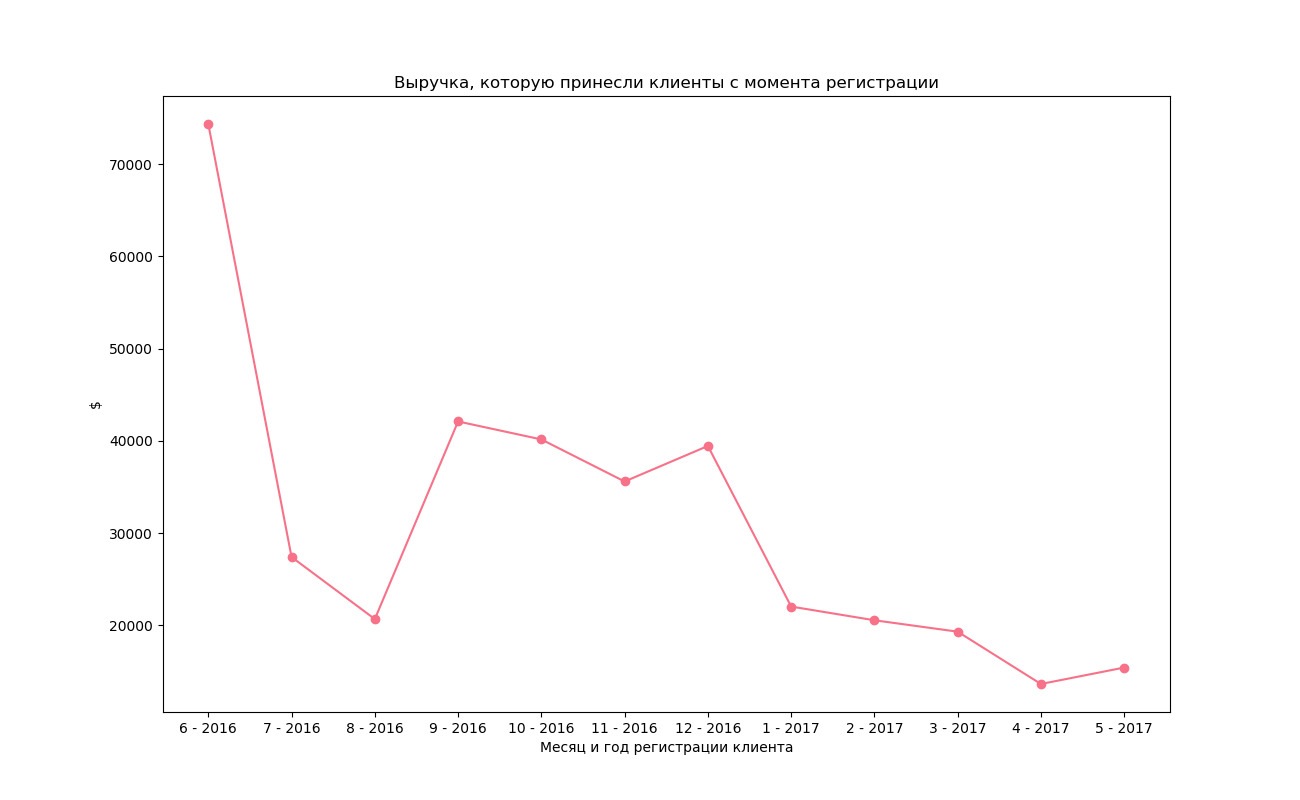

In [264]:
plt.figure(figsize=(13,8))
plt.plot(list(sorted_df['total_revenue']), marker='o')

plt.xticks(range(12), list(sorted_df['first_visit']))

plt.xlabel('Месяц и год регистрации клиента')
plt.ylabel('$')
plt.title('Выручка, которую принесли клиенты с момента регистрации')
plt.show()

In [260]:
ltv_uid = pd.DataFrame(final_df.groupby(['year', 'month'])['LTV uid'].sum()).reset_index()

ltv_uid['first_visit'] = ltv_uid['month'].apply(lambda x: str(x)).values + ' - ' + ltv_uid['year'].apply(lambda x: str(x)).values

<IPython.core.display.Javascript object>


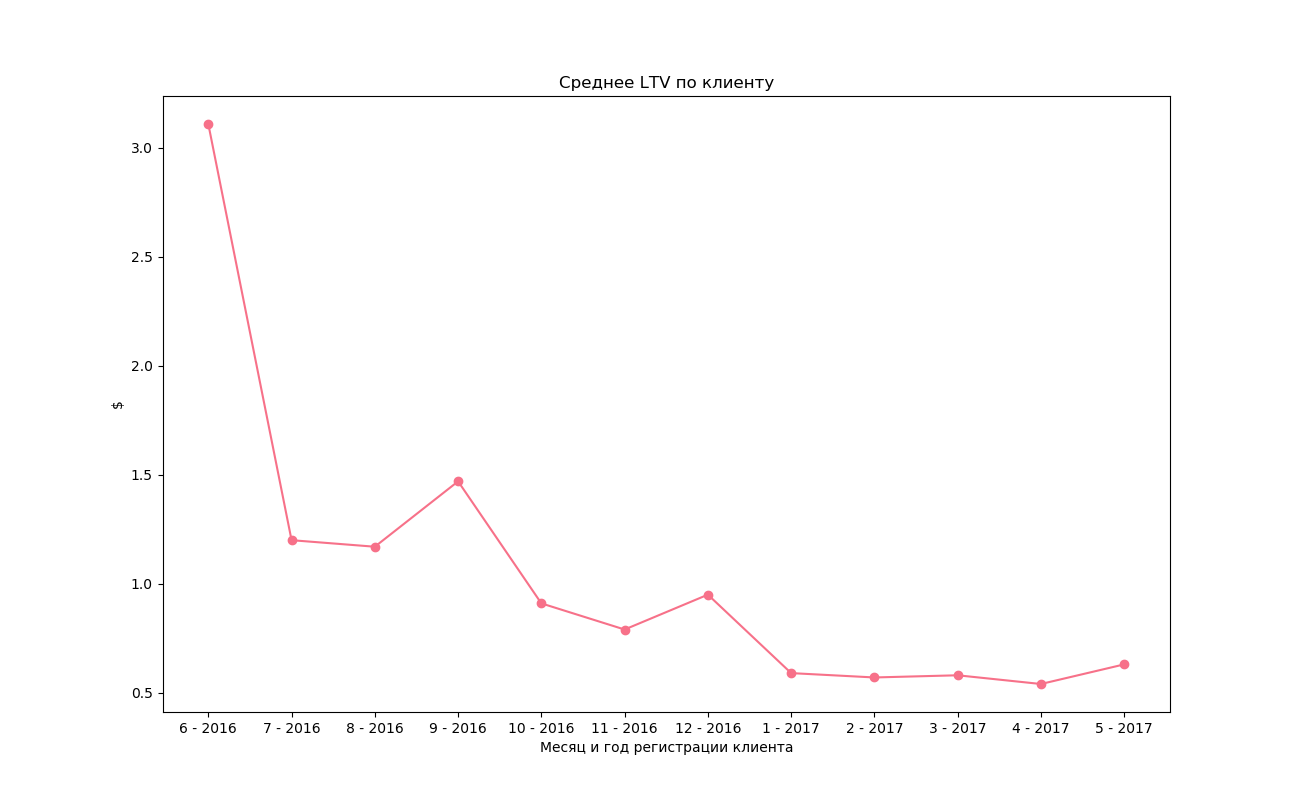

In [266]:
plt.figure(figsize=(13,8))
plt.plot(list(ltv_uid['LTV uid']), marker='o')

plt.xticks(range(12), list(ltv_uid['first_visit']))

plt.xlabel('Месяц и год регистрации клиента')
plt.ylabel('$')
plt.title('Среднее LTV по клиенту')
plt.show()

In [258]:
rev_a_month = pd.DataFrame(final_df.groupby(['year', 'month'])['revenue a month'].sum()).reset_index()

rev_a_month['first_visit'] = rev_a_month['month'].apply(lambda x: str(x)).values + ' - ' + rev_a_month['year'].apply(lambda x: str(x)).values

На графике ниже наблюдается сезонность: сентябрь - декабрь

<IPython.core.display.Javascript object>


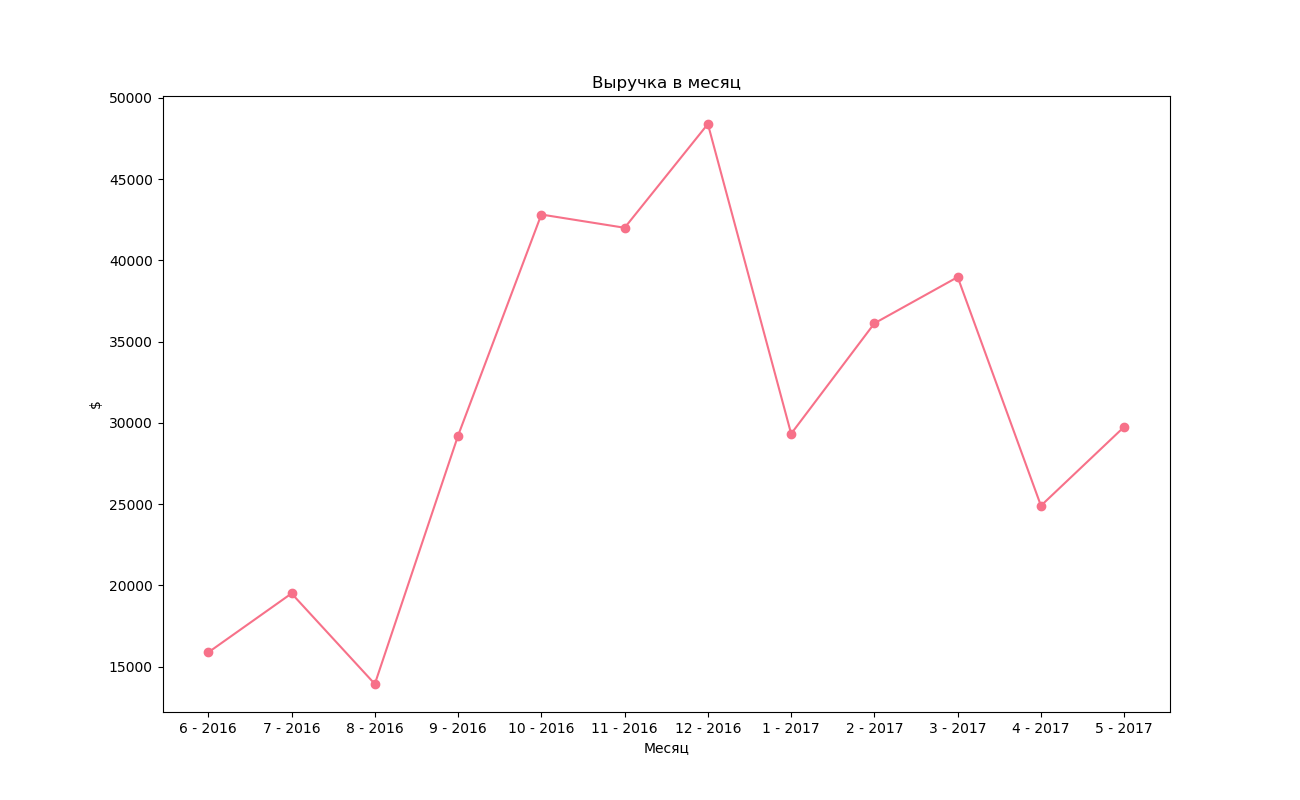

In [267]:
plt.figure(figsize=(13,8))
plt.plot(list(rev_a_month['revenue a month']), marker='o')

plt.xticks(range(12), list(rev_a_month['first_visit']))

plt.xlabel('Месяц')
plt.ylabel('$')
plt.title('Выручка в месяц')
plt.show()

In [244]:
final_df

,first_visit,all_visits,unique_uids_visited,uids_registered,total_revenue,LTV uid,revenue a month,month,year
0,1 - 2017,74137,51277,37361,22052.41,0.59,29329.11,1,2017
1,10 - 2016,75873,52736,43906,40160.43,0.91,42821.86,10,2016
2,11 - 2016,88579,57289,44850,35603.62,0.79,42006.80,11,2016
3,12 - 2016,83820,55090,41313,39452.73,0.95,48393.27,12,2016
4,2 - 2017,74598,51085,36239,20566.14,0.57,36126.37,2,2017
5,3 - 2017,71639,48668,33234,19328.77,0.58,38971.17,3,2017
6,4 - 2017,52865,37468,25415,13659.94,0.54,24899.93,4,2017
7,5 - 2017,53693,36824,24675,15440.87,0.63,29756.15,5,2017
8,6 - 2016,32935,23926,23926,74339.46,3.11,15873.54,6,2016
9,7 - 2016,35409,25352,22779,27416.66,1.20,19501.34,7,2016


In [281]:
first_visit_date = pd.DataFrame(visits.groupby('uid')['start_ts_datetime'].min()).reset_index()

In [282]:
first_visit_date.head()

,uid,start_ts_datetime
0,4245,2016-11-15 09:11:16
1,5097,2017-02-18 23:00:30
2,8896,2017-01-03 19:44:56
3,21017,2016-06-14 17:16:17
4,30696,2016-11-26 14:01:27


In [283]:
purchases[['uid', 'revenue', 'buy_ts_datetime']].head()

,uid,revenue,buy_ts_datetime
0,3492372810,"1,47",2016-07-23 19:13:54
1,1564753091,"1,11",2016-11-06 02:48:27
2,1385616391,"16,8",2017-01-31 20:32:42
3,2636761148,11,2017-01-11 10:52:11
4,2945629974,"4,89",2016-11-25 18:57:09


In [284]:
first_visit_date['login_time'] = (first_visit_date['start_ts_datetime'].astype(int) / 1_000_000_000).astype(int)

In [285]:
profiles = first_visit_date[['uid','login_time']]
profiles = profiles.rename(columns = {'uid': 'user_id', 'login_time' : 'login_time'})
profiles.head()

,user_id,login_time
0,4245,1479201076
1,5097,1487458830
2,8896,1483472696
3,21017,1465924577
4,30696,1480168887


In [286]:
pays = purchases[['uid', 'revenue', 'buy_ts_datetime']]
pays['pay_time'] = (pays['buy_ts_datetime'].astype(int) / 1_000_000_000).astype(int)
pays = pays.rename(columns = {'uid': 'user_id', 'revenue' : 'pay_sum'})[['user_id','pay_sum','pay_time']]

In [287]:
pays['pay_sum'] = pays['pay_sum'].apply(lambda x: x.replace(',', '.')).astype(float)

In [288]:
pays.head()

,user_id,pay_sum,pay_time
0,3492372810,1.47,1469301234
1,1564753091,1.11,1478400507
2,1385616391,16.80,1485894762
3,2636761148,11.00,1484131931
4,2945629974,4.89,1480100229


In [289]:
pays.dtypes

user_id       int64
pay_sum     float64
pay_time      int64
dtype: object

In [290]:
import numpy as np
import pandas as pd
import re
import shutil
import os
import errno
import numpy as np

import calendar
from datetime import datetime
import time
import pytz
import warnings
from scipy.optimize import curve_fit, OptimizeWarning

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100

import matplotlib
import matplotlib.pyplot as plt
import numpy as np


def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

            
class ShowContext():
    def __init__(self, title, xlabel, ylabel, figsize=(12,7), show_legend=True):
        self._title = title
        self._xlabel = xlabel
        self._ylabel = ylabel
        self._figsize = figsize
        self._show_legend = show_legend

    def __enter__(self):
        fig = plt.figure(figsize=self._figsize)
        plt.title(self._title)
        plt.xlabel(self._xlabel)
        plt.ylabel(self._ylabel)
        plt.minorticks_on()
        
        # Customize the major grid
        plt.grid(which='major', linestyle='-', color=[0.8]*3)
        # Customize the minor grid
        plt.grid(which='minor', linestyle=':', color=[0.9]*3)
        return fig

    def __exit__(self, *args):
        if self._show_legend:
            plt.legend()
        
def to_ut(x, fmt='%Y-%m-%d %H:%M:%S'):
    if x=='nan':
        return None
    else:
        return calendar.timegm(datetime.strptime(x, fmt).timetuple())

def get_ut(year, month, day):
    return  calendar.timegm(datetime(year, month, day).timetuple())

In [291]:
def func(x, a, b, c):
#     return 50*np.tanh(a)*np.log(x + 500*np.tanh(b)) + 100*np.tanh(c)
    return a*np.log(x + b) + c

def get_cohs(profiles, payments):
    COH_SIZE = 1
    # Add cohorts numbers
    MIN_TS = profiles['login_time'].min()
    profiles['coh'] = (profiles['login_time'] - MIN_TS) // (COH_SIZE*3600*24)
    profiles = profiles.loc[profiles['coh'] >= 0]
    
    cohs_sizes = profiles.groupby('coh').agg({'user_id': 'nunique', 
                                        'login_time': 'max'}
                                      ).reset_index().rename(index=str, columns={'user_id': 'coh_size'})
    cohs_sizes['last_day'] = max(payments['pay_time'].max(), cohs_sizes['login_time'].max())
    cohs_sizes['max_day'] = (cohs_sizes['last_day'] - cohs_sizes['login_time']) // (24*3600)
    cohs_sizes = cohs_sizes[['coh', 'coh_size', 'max_day']]

    zeros_df = pd.concat([pd.DataFrame({'coh': coh, 
                                        'coh_size': coh_size,
                                        'days_passed': list(range(int(max_day)+1))
                      }) for idx, (coh, coh_size, max_day) in cohs_sizes.iterrows()])
        
    project = pd.merge(profiles, payments, on='user_id') 
    project['days_passed'] = (project['pay_time'] - project['login_time']) // (24*3600)
        
    project_sum = project.groupby(['coh', 'days_passed'])['pay_sum'].sum().reset_index()
    project_sum = pd.merge(zeros_df, project_sum, on=['coh', 'days_passed'], how='left').fillna(0)    
    return project, cohs_sizes, project_sum
    
    
def predict_LTV(profiles0, payments0):
    profiles = profiles0.copy()
    payments = payments0.copy()
    ltv={}
    res_popt = {}
    project, cohs_sizes, project_sum = get_cohs(profiles, payments)    
    project_sum_upd = project_sum.copy()
    data_avg = project_sum_upd.groupby('days_passed').agg({'pay_sum': 'sum', 
                                                               'coh_size': 'sum'}).reset_index()
    data_avg['ARPU'] = data_avg['pay_sum'] / data_avg['coh_size']
    data_avg['LTV'] = data_avg['ARPU'].cumsum() #/ 60
    data_avg['sigma'] = 1 / (data_avg['coh_size']**0.5)
    data_mean_all = project_sum_upd.copy()
    data_mean_all['cum_sum'] = project_sum_upd.groupby('coh')['pay_sum'].cumsum()
    data_mean_all['LTV'] = data_mean_all['cum_sum'] / data_mean_all['coh_size']
    data_mean_all['LTV'] = data_mean_all['LTV'] #/ 60
    data_mean_all['sigma'] = 1 / (data_mean_all['coh_size'])**0.5
    n_players = int(project_sum_upd[['coh', 'coh_size']].drop_duplicates()['coh_size'].sum())

    title = 'asdasdasdasd'
    with ShowContext(title, 'Days', 'LTV USD', show_legend=False, figsize=(9,7)) as sc:
        sns.set_palette(sns.color_palette('husl', project_sum_upd['coh'].nunique()))
        for coh, group in data_mean_all.groupby('coh'):
            coh_cnt = int(cohs_sizes.loc[(cohs_sizes['coh'] == coh)]['coh_size'])
            plt.plot(group['days_passed'], group['LTV'],alpha = coh_cnt / project_sum_upd['coh_size'].max())    
            plt.plot(data_avg['days_passed'], data_avg['LTV'], linewidth=5, color='green')
                
            Q=1.645
            delta = data_avg['LTV'] * Q * data_avg['sigma']
            plt.fill_between(data_avg['days_passed'], data_avg['LTV']-delta, data_avg['LTV']+delta,
                                color='green', alpha=0.4)
            popt, pcov = curve_fit(func, data_avg['days_passed'], data_avg['LTV'].astype('float'),
                              sigma=data_avg['sigma'], absolute_sigma=True, maxfev = 100000, p0=(1,1,-1))
            days = np.linspace(0, 720, 721)
            LTV = [func(x, *popt) for x in days]   #Взвешенное среднее всех когорт
            plt.plot(days, LTV, linewidth=3, color='orange', linestyle=':')
            plt.ylim((0,func(720, *popt)*1.1))
            plt.show()
    return res_popt, ltv

<IPython.core.display.Javascript object>


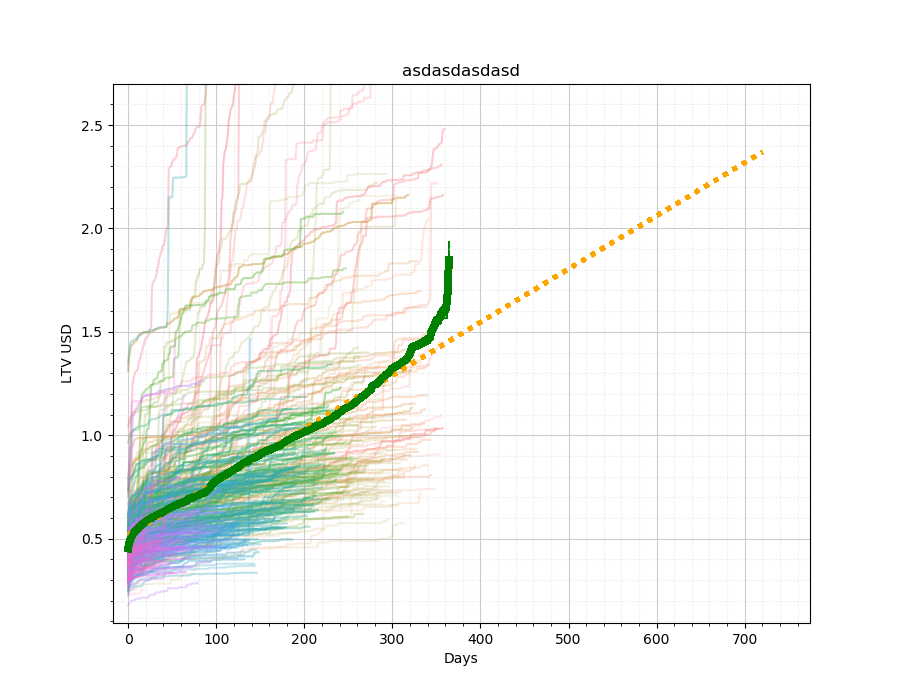

KeyboardInterrupt: 

In [292]:
%%time
a,b = predict_LTV(profiles, pays)

In [129]:
%%time
a,b,c = get_cohs(profiles, pays)

CPU times: user 710 ms, sys: 76.4 ms, total: 787 ms
Wall time: 473 ms


In [54]:
visits[visits['uid'] == 1572918479].head()

,device,end_ts,source_id,start_dt,start_ts,uid,start_ts_datetime,end_ts_datetime,month_year
15,desktop,2016-12-09T21:47:40Z,2,2016-12-09,2016-12-09T21:42:30Z,1572918479,2016-12-09 21:42:30,2016-12-09 21:47:40,12 - 2016
3549,desktop,2016-12-04T01:08:43Z,2,2016-12-04,2016-12-04T01:05:13Z,1572918479,2016-12-04 01:05:13,2016-12-04 01:08:43,12 - 2016
30514,desktop,2016-11-08T21:43:52Z,4,2016-11-08,2016-11-08T21:15:19Z,1572918479,2016-11-08 21:15:19,2016-11-08 21:43:52,11 - 2016
30944,desktop,2016-12-01T21:24:26Z,2,2016-12-01,2016-12-01T20:13:47Z,1572918479,2016-12-01 20:13:47,2016-12-01 21:24:26,12 - 2016
35750,desktop,2016-10-22T21:10:28Z,3,2016-10-22,2016-10-22T20:59:30Z,1572918479,2016-10-22 20:59:30,2016-10-22 21:10:28,10 - 2016


In [575]:
first_visit[first_visit['uid'] == 1572918479]

,uid,first_visit
138909,1572918479,2016-10-22 20:59:30


In [569]:
merged_df.shape

(75716, 12)

In [570]:
visits.shape

(720679, 9)

In [571]:
purchases.shape

(75716, 4)

In [309]:
purchases.shape[0]/visits.shape[0]

0.10506203177836457

In [452]:
sum(purchases['revenue'].apply(lambda x: float(x.replace(',', '.'))))/pd.DataFrame(purchases['uid']).drop_duplicates(keep='first').shape[0]



6.646307488259452

In [422]:
pd.DataFrame(purchases['uid']).drop_duplicates(keep='first').shape[0]

55794

In [447]:
pd.DataFrame(visits['uid']).drop_duplicates(keep='first').shape[0]

380121

In [ ]:
767950

In [ ]:
5097

In [467]:
visits[visits['uid'] == 767950]

,device,end_ts,source_id,start_dt,start_ts,uid,start_ts_datetime,end_ts_datetime
11676,touch,2017-03-12T17:22:23Z,2,2017-03-12,2017-03-12T16:53:19Z,767950,2017-03-12 16:53:19,2017-03-12 17:22:23
67261,touch,2016-10-02T11:49:12Z,2,2016-10-02,2016-10-02T11:43:20Z,767950,2016-10-02 11:43:20,2016-10-02 11:49:12
686533,touch,2017-03-12T17:28:02Z,1,2017-03-12,2017-03-12T16:53:48Z,767950,2017-03-12 16:53:48,2017-03-12 17:28:02


In [454]:
purchases[purchases['uid'] == 3492372810]

,buy_ts,uid,revenue,buy_ts_datetime
0,23.07.2016 19:13:54,3492372810,"1,47",2016-07-23 19:13:54
66264,18.04.2017 15:19:31,3492372810,"0,49",2017-04-18 15:19:31


In [455]:
visits.shape, purchases.shape, merged_df.shape

((720679, 8), (75716, 4), (75716, 11))